In [0]:
import re, string, unicodedata, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

from collections import Counter
from itertools import chain

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

In [0]:
STOPWORDS = stopwords.words('portuguese')

blind = {
    "<url>": "",
    "<empty>": "",
}

In [0]:
def color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    COLORS = ['#b58900', '#cb4b16', '#dc322f', 
          '#d33682', '#6c71c4', '#268bd2', '#2aa198', '#859900']
    return COLORS[random.randint(0, len(COLORS)-1)]

def convert(x):
  x = str(x)
  return f'{x[:4]}-{x[4:]}'

def re_sub(text, pattern, repl):
    return re.sub(pattern, repl, text)


def remove_non_ascii(text):
    new_tokens = []
    tokens = text.split()
    
    for token in tokens:
        token = unicodedata.normalize('NFKD', token).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_tokens.append(token)
    
    return ' '.join(new_tokens)


def remove_punctuation(text):
    tokens = [c for c in text if c not in string.punctuation]
                
    return ''.join(tokens)


def strip_text(text):
    return text.strip()


def remove_stopwords(text):
    tokens = text.split()
    tokens = [token for token in tokens if token not in STOPWORDS]
                
    return ' '.join(tokens)


def normalize_serie(text):
    text = text.lower()
    text = remove_stopwords(text)
    text = remove_non_ascii(text)
    
    text = re_sub(text, r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", blind["<url>"])
    text = re_sub(text, r"\b(\w*rt\w*)\b", blind["<empty>"])
    text = re_sub(text, r"\b(\w*jairbolsonaro\w*)\b", blind["<empty>"])
    text = re_sub(text, r"\b(k+)\b", blind["<empty>"])
    text = re_sub(text, r"\b(\d+)\b", blind["<empty>"])
    
    text = strip_text(text)
    text = remove_punctuation(text)

    return text

In [0]:
f = "jairbolsonaro.csv"

In [0]:
df = pd.read_csv(f, date_parser=['created_at'])

In [6]:
df.head()

,id,text,retweet_count,favorite_count,created_at
0,1079955754537365504,FELIZ 2019 🇧🇷🇧🇷🇧🇷,19546,145806,2019-01-01T04:21:31.000Z
1,1079958436211773440,Nos vemos na posse. Um forte abraço!,7118,80676,2019-01-01T04:32:10.000Z
2,1080071345248051201,"Não é a primeira fakenews do ano, mas vale uma...",3957,39040,2019-01-01T12:00:50.000Z
3,1080132746805161985,- Palavras antes da posse!\n- Um forte abraço ...,13805,94216,2019-01-01T16:04:49.000Z
4,1080168100509687808,"Dear Mr. President @realDonalTrump, I truly ap...",19091,105325,2019-01-01T18:25:18.000Z


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551 entries, 0 to 2550
Data columns (total 5 columns):
id                2551 non-null int64
text              2551 non-null object
retweet_count     2551 non-null int64
favorite_count    2551 non-null int64
created_at        2551 non-null object
dtypes: int64(3), object(2)
memory usage: 99.8+ KB


In [0]:
df['YearMonth'] = pd.to_datetime(df['created_at']).apply(lambda x: int(f'{x.year}{x.month}'))
df['normalized'] = df['text'].apply(normalize_serie)

regex_mention = r'(@\w+)'
df['mentions'] = df.text.apply(lambda x: ' '.join(re.findall(regex_mention, x)))

In [9]:
res = df.groupby('YearMonth')['id'].count()
print(res)

YearMonth
20191     276
20192     212
20193     240
20194     235
20195     246
20196     174
20197     190
20198     169
20199     197
201910    346
201911    209
201912     57
Name: id, dtype: int64


In [10]:
X = tuple(map(convert, res.index))
Y = res.values

fig = go.Figure(data=[go.Scatter(x=X, y=Y, text=Y)])
fig.update_layout(title='Tweets per month - @jairbolsonaro', 
                  xaxis_title='Month', yaxis_title='Tweets')

fig.show()

In [11]:
idx_retweet_count = df.groupby('YearMonth')['retweet_count'].transform(max) == df['retweet_count']
x = df[idx_retweet_count]['YearMonth'].apply(convert)

retweet_count = df[idx_retweet_count]['retweet_count']
hovertext = df[idx_retweet_count]['text']

fig = go.Figure(data=[go.Bar(
    x=x, 
    y=retweet_count,
    text=retweet_count,
    textposition='auto',
    hovertext=hovertext,
  )
])

fig.update_layout(title='Tweets most retweeted per month - @jairbolsonaro')

fig.show()

In [12]:
idx_favorite_count = df.groupby('YearMonth')['favorite_count'].transform(max) == df['favorite_count']

favorite_count = df[idx_favorite_count]['favorite_count']
hovertext = df[idx_favorite_count]['text']

fig = go.Figure(data=[go.Bar(
    x=x, 
    y=favorite_count,
    text=favorite_count,
    textposition='auto',
    hovertext=hovertext,
  )
])

fig.update_layout(title='Tweets most favorited per month - @jairbolsonaro')

fig.show()

In [13]:
fig = go.Figure(data=[
                      go.Bar(name='Retweet', x=x, y=retweet_count, text=retweet_count, textposition='auto'),
                      go.Bar(name='Favorite', x=x, y=favorite_count, text=favorite_count, textposition='auto')
])
fig.update_layout(title='Retweets <i>vs</i> Favorite tweets - @jairbolsonaro', barmode='group')
fig.show()

In [14]:
mentions = df.loc[df.text.str.contains('@')].groupby('YearMonth', as_index=False).count().sort_values(by='YearMonth')['id'].values
fig = go.Figure(data=go.Bar(name='Mentions', x=x, y=mentions, 
                            text=mentions, textposition='auto'))
fig.update_layout(title='Tweets that mention some user - @jairbolsonaro')
fig.show()

In [15]:
rts = df.loc[df.text.str.contains('RT ')].groupby('YearMonth', as_index=False).count().sort_values(by='YearMonth')['id'].values
fig = go.Figure(data=go.Bar(name='Mentions', x=x, y=rts, 
                            text=rts, textposition='auto'))
fig.update_layout(title='Retweets per Month - @jairbolsonaro')
fig.show()

In [16]:
not_rts = Y - rts

fig = go.Figure(
    data=[
         go.Bar(name='Tweets', x=x, y=not_rts, text=not_rts, textposition='auto'),
         go.Bar(name='RT', x=x, y=rts, text=rts, textposition='auto'),
])

fig.update_layout(title='Tweets composition per month - @jairbolsonaro', 
                  barmode='stack')

fig.show()

In [0]:
df['Hour'] = pd.to_datetime(df['created_at']).apply(lambda x: int(x.hour))

In [18]:
hours = df[['Hour', 'id']].groupby('Hour', as_index=False).count().sort_values(by='Hour')

fig = go.Figure(
      data=[go.Bar(x=hours['Hour'], y=hours['id'], 
                   text=hours['id'], textposition='auto')
      ],
)

fig.update_layout(title='Tweet Frequency by hour - @jairbolsonaro')
fig.show()

In [0]:
df['WeekDay'] = pd.to_datetime(df['created_at']).apply(lambda x: x.strftime('%w'))

In [20]:
weekdays = df[['WeekDay', 'id']].groupby('WeekDay', as_index=False).count().sort_values(by='WeekDay')
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',]

fig = go.Figure(data=[go.Bar(x=days, y=weekdays['id'], text=weekdays['id'], textposition='auto')])
fig.update_layout(title='Tweet Frequency by day of week - @jairbolsonaro')

fig.show()

In [21]:
months_week = df[['YearMonth', 'WeekDay', 'id']].groupby(['YearMonth', 'WeekDay'], as_index=False).count()
  
fig = go.Figure()

fig.add_scatter(
    x=months_week['YearMonth'].apply(convert), 
    y=months_week['WeekDay'].apply(lambda x: days[int(x)]), mode='markers', 
    marker_color=[
                  '#b58900', '#cb4b16', '#dc322f', 
                  '#d33682', '#6c71c4', '#268bd2', 
                  '#2aa198',
                ] * len(x),
    text=months_week['id'],
    marker=dict(size=months_week['id'] * .5)
)

fig.update_layout(title='Tweets frenquency by day of week per month - @jairbolsonaro')

fig.show()

In [22]:
months_week = df[['WeekDay', 'Hour', 'id']].groupby(['WeekDay', 'Hour'], as_index=False).count()
  
fig = go.Figure()

fig.add_scatter(
    x=months_week['WeekDay'].apply(lambda x: days[int(x)]), 
    y=months_week['Hour'], mode='markers', text=months_week['id'],
    marker=dict(size=months_week['id']*.5)
)

fig.update_layout(title='Tweets frenquency by hour per week - @jairbolsonaro')

fig.show()

In [0]:
all_mentions = []
for year in X:
  
  mentions = []
  mentions_ = df.loc[
                    (df.YearMonth == int(year.replace('-', ''))) 
                    & (df.mentions != '')
                    & (df.text.str.contains('RT ') == False)
                  ]['mentions'].values
  for m in mentions_:
    for mention in m.split():
      mentions.append(mention)
  
  all_mentions.append(mentions)

In [0]:
counter = []
for mentions in all_mentions:
  counter.append(Counter(mentions))

In [0]:
mentions = []

for co in counter:
  for mention in list(co.most_common()):
    values = []
    name = mention[0]

    if name in mentions:
      continue
    
    for co in counter:
      if name in chain(*co.most_common()):
        for mention in list(co.most_common()):
          if mention[0] == name:
            values.append(mention[1])
      else:
        values.append(0)

    mentions.append((name, values))

In [26]:
mentions[0]

('@netanyahu', [5, 0, 1, 2, 1, 0, 0, 0, 3, 0, 0, 0])

In [27]:
fig = go.Figure()

for mention in mentions:
  fig.add_trace(go.Scatter(x=x, y=mention[1], name=mention[0], mode='lines'))

fig.update_layout(title='Mentions per month - @jairbolsonaro',)

fig.show()

In [0]:
wordcloud = WordCloud(
    width=3000,
    height=2000,
    background_color='#073642',
    collocations=False,
    
).generate(' '.join(df['normalized'].values))

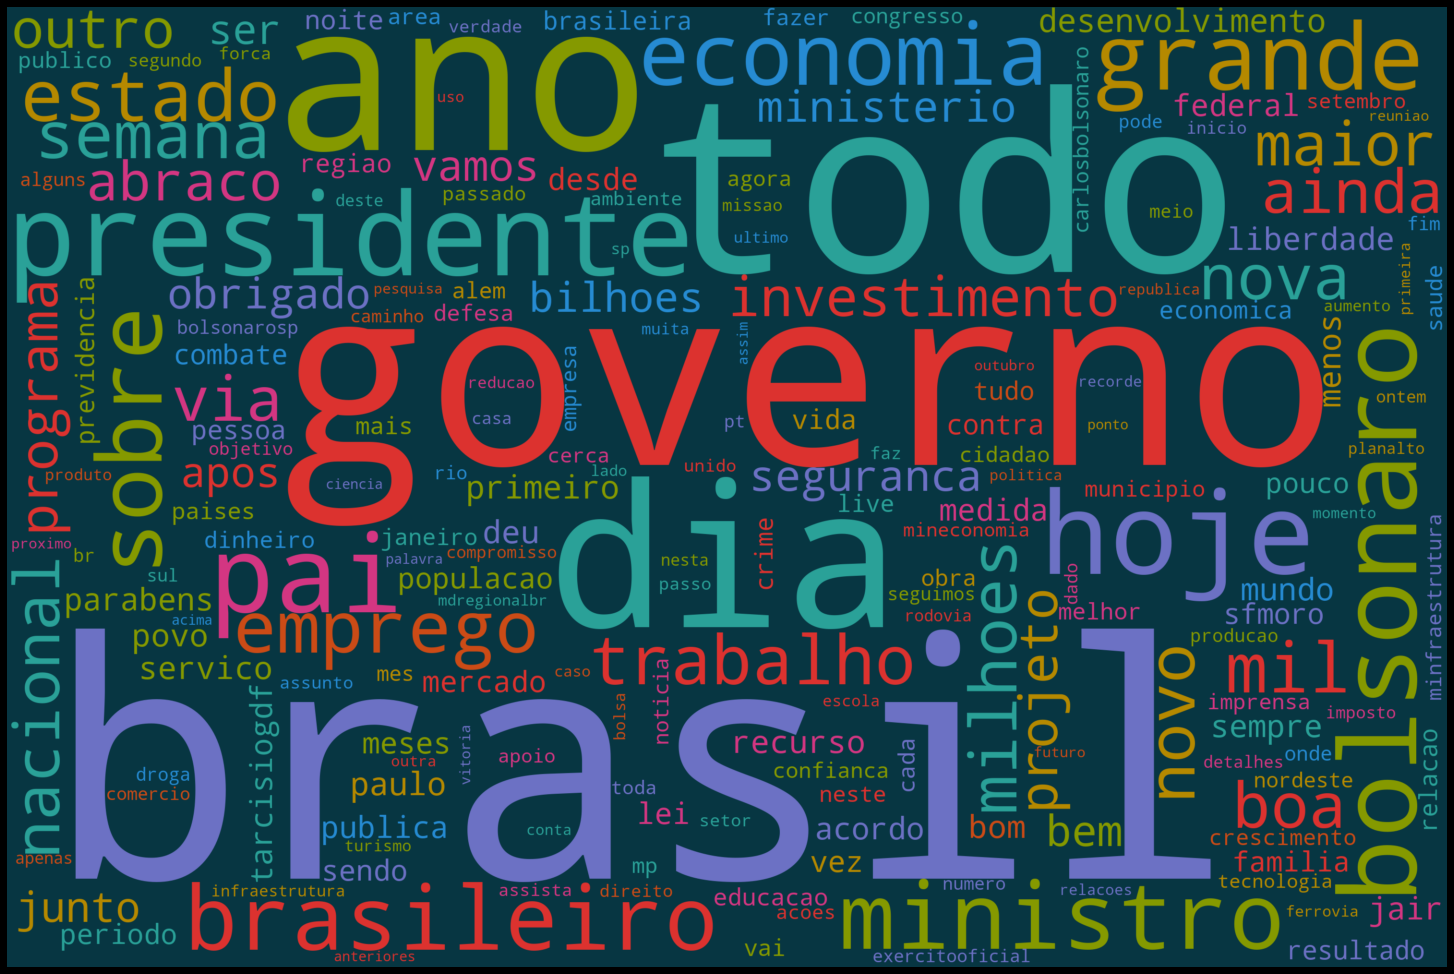

In [29]:
fig = plt.figure(
    figsize=(20, 15),
    facecolor='k',
    edgecolor='k'
)

plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud.recolor(color_func=color_func, random_state=3),
           interpolation="bilinear")
plt.show()